In [338]:
pr_file_name = "20230831_060603_pr_sharings.json"

In [339]:
import json
import re
import nltk
import pandas as pd
from nltk.corpus import words
nltk.download('words')
english_words = set(words.words())
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import mannwhitneyu
import numpy as np

[nltk_data] Downloading package words to /Users/marjann/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [341]:
# Load the JSON file
with open(pr_file_name, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract all conversations
prs = {}

def filter_non_english_words(text):
    words_list = text.split()
    filtered_words = [word for word in words_list if word.lower() in english_words]
    return ' '.join(filtered_words)

def filter_prompt(prompt):
    prompt = re.sub(r'\s+', ' ', prompt).strip()
    prompt = re.sub(r'<[^>]*>.*?</[^>]*>', '', prompt, flags=re.DOTALL)
    prompt = re.sub(r'[^a-zA-Z0-9\s]', '', prompt)
    prompt = filter_non_english_words(prompt)
    return prompt

counter = 1
for source in data.get("Sources", []):  # Loop through each Source
    isClosed = source.get("ClosedAt", [])
    if isClosed is None:
        continue # we're only considering closed PRs
    for sharing in source.get("ChatgptSharing", []):  # Loop through ChatgptSharing
        counter += 1
        conversations = sharing.get("Conversations", [])  # Extract Conversations
        prompts = []
        for conversation in conversations:
            prompt = conversation['Prompt']
            prompt = filter_prompt(prompt)
            answer = conversation['Answer']
            answer = filter_prompt(answer)
            if len(prompt) == 0:
                continue
            prompts.append(prompt)
    # PR LEVEL
    if len(prompts) == 0:
        continue
    timeOpened      = source.get("CreatedAt", [])
    timeClosed      = source.get("ClosedAt", [])
    isMerged        = 1 if source.get("MergedAt", []) is not None else 0
    timeMerged      = source.get("MergedAt")
    additions       = source.get("Additions")
    deletions       = source.get("Deletions")
    changedFiles    = source.get("ChangedFiles")
    commitsTotal    = source.get("CommitsTotalCount")
    numConversations    = len(conversations)
    prs[source.get("Number", [])] = (timeOpened, timeClosed, isMerged, timeMerged, additions, deletions, changedFiles, commitsTotal, numConversations, prompts)
print(counter)

198


In [131]:
df = pd.DataFrame.from_dict(prs)
df = pd.DataFrame.from_dict(prs, orient='index', columns=[ "tOpen", "tClose", "isMerge", "tMerge", "nAdd", "nDel", "changeFile", "nCommits", "nConvos", "prompts"])
df = df.reset_index()
df.groupby(["isMerge"]).index.count()

isMerge
0    20
1    93
Name: index, dtype: int64

In [ ]:
# df.to_excel("prompts.xlsx")
liwc_df = pd.read_excel("22-liwc.xlsx")

/Users/marjann/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## Psychological Safety

In [264]:
# voice_words     = [r"sorry", r"mistake", r"apolog.*", r"incorrect", 
#                     r"disagree", r"wrong", r"impossible", r"unlikely", 
#                     r"don’t think", r"don’t know", r"unsure", r"help", 
#                     r"who", r"what", r"where", r"why", r"how", r"\?"]
# support_words   = [r"yes", r"yeah", r"ya", r"yea", r"agree.*" 
#                 r"congrat.*", r"amazing", r"amaze.*", r"wonderful", r"wow", r"thank.*"]
# fam_words       = [r";[^/^\\^]*?:", r"hah.*", r"aha.*", r"lol.*", r"lmao.*", r"jok.*"]
# learning_words  = [r"improv.*", r"better", r"instead", r"actual.*", r"what if" 
#                 r"feedback", r"share", r"thoughts", r"idea.*"]
                
# ps_words = voice_words + support_words + fam_words + learning_words

# # FUNCTION TO COUNT MATCHES
# def count_matches(prompt, list_words):
#     return sum(bool(re.search(pattern, prompt)) for pattern in list_words)

# # APPLY THE FUNCTION
# categories = [("voice_count", voice_words), ("support_count", support_words), 
#              ("fam_count", fam_words), ("learning_count", learning_words), ("ps", ps_words)]
# for category in categories:
#     # divided by the number of prompts
#     print()
#     print(category[0])
#     df[category[0]] = df["prompts"].apply(lambda x: count_matches(str(x), category[1])/len(x))
#     merge_df = (df[df['isMerge'] == 1][category[0]]).copy()
#     unmerge_df = (df[df['isMerge'] == 0][category[0]]).copy()
#     print(df.groupby(['isMerge'])[category[0]].mean())
#     t_stat, p_value = stats.ttest_ind(merge_df, unmerge_df)
#     # Print the results
#     print("t-statistic:", t_stat)
#     print("p-value:", p_value)

#     # Interpretation of the p-value:
#     alpha = 0.05  # 5% significance level
#     if p_value < alpha:
#         print("The difference between the groups is statistically significant.")
#     else:
#         print("The difference between the groups is not statistically significant.")

In [265]:
# # # List of columns you're interested in
# columns_of_interest = ["isMerge", "ps"]

# # # # Select only the columns of interest
# # # df_subset = df[columns_of_interest]

# # # Calculate the correlation matrix
# # # liwc_df_subset = liwc_df.drop(columns={"tOpen", "tClose", "tMerge", "prompts"})
# liwc_df_subset = liwc_df[columns_of_interest].copy()
# corr_matrix = liwc_df_subset.corr()

# # Create the heatmap
# plt.figure(figsize=(11, 10))  # Adjust the size if necessary
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Correlation Heatmap of Selected Columns')
# plt.show()

## RQ1

### assumptions

In [304]:
category = "ps"
group_1 = liwc_df[liwc_df['isMerge'] == 1][category].copy()
group_2 = liwc_df[liwc_df['isMerge'] == 0][category].copy()
stat_1, p_1 = shapiro(group_1)
stat_2, p_2 = shapiro(group_2)
print(f"Group 1: {stat_1} p-value = {p_1}")
print(f"Group 2: {stat_2} p-value = {p_2}")
stat, p = levene(group_1, group_2)
print(f"Levene's Test {stat} p-value = {p}")

Group 1: 0.9438502626055965 p-value = 0.00056575542211692
Group 2: 0.876148566825772 p-value = 0.015094864522788208
Levene's Test 0.6464203615182721 p-value = 0.42311393768030736


In [302]:
liwc_df.groupby(['isMerge'])['ps'].describe()

,count,mean,std,min,25%,50%,75%,max
isMerge,,,,,,,,
0,20.0,6.894062,5.895949,0.0,1.475625,4.505625,12.064687,16.60375
1,93.0,9.886455,5.379341,0.0,5.078750,10.667500,14.647500,19.34500


In [311]:
    # next: think of categories to combine for PS and its individual categories
    # SUPPORT
    # LEARNING
    # VOICE
    # FAMILIARITY 

    """
    THE T-TESTS 
    """ 
    categories = ["ps", "fam", "support", "learning", "voice"]
    for category in categories:
        print()
        print(category)
        merge_df = (liwc_df[liwc_df['isMerge'] == 1][category]).copy()
        unmerge_df = (liwc_df[liwc_df['isMerge'] == 0][category]).copy()
        print(liwc_df.groupby(['isMerge'])[category].mean())

        # Perform the Mann-Whitney U test
        stat, p_value = mannwhitneyu(merge_df, unmerge_df)

        # Print the results
        print(f"Mann-Whitney U statistic: {stat}")
        print(f"P-value: {p_value}")

        # # Print the results
        # print("t-statistic:", t_stat)
        # print("p-value:", p_value)


ps
isMerge
0    6.894062
1    9.886455
Name: ps, dtype: float64
Mann-Whitney U statistic: 1220.0
P-value: 0.02935565225699594

fam
isMerge
0    1.568000
1    0.541075
Name: fam, dtype: float64
Mann-Whitney U statistic: 798.0
P-value: 0.15959889470093735

support
isMerge
0    0.000000
1    0.175735
Name: support, dtype: float64
Mann-Whitney U statistic: 1210.0
P-value: 0.005530976516482099

learning
isMerge
0    5.250750
1    7.902312
Name: learning, dtype: float64
Mann-Whitney U statistic: 1161.0
P-value: 0.08260465503039674

voice
isMerge
0    21.520500
1    31.037688
Name: voice, dtype: float64
Mann-Whitney U statistic: 1181.5
P-value: 0.058740357117218395


In [ ]:
""" RQ1: Is there a difference in PS composition between merged and non-merged devGPT pull requests? """
""" RQ2: How about when we control for the complexity of the PR? """ 

""" CHECK NORMALITY ASSUMPTIONS """

' RQ2: Are all sub-components of PS equally responsible for the association, or lack thereof? '

In [331]:
liwc_df = pd.read_excel("22-liwc.xlsx")
learning_categories = ['cogproc', 'curiosity']
liwc_df['learning'] = liwc_df[learning_categories].mean(axis=1)

support_categories = ["assent", "emo_pos", "polite"]
liwc_df['support'] = liwc_df[support_categories].mean(axis=1)

familiarity_categories = ['Conversation']
liwc_df['fam'] = liwc_df[familiarity_categories].mean(axis=1)
liwc_df['fam'] = liwc_df['fam'].fillna(0)

voice_categories = ['Authentic', 'differ']
liwc_df['voice'] = liwc_df[voice_categories].mean(axis=1)
liwc_df['voice'] = liwc_df['voice'].fillna(0)

ps_categories = learning_categories + support_categories + familiarity_categories + voice_categories
liwc_df['ps'] = liwc_df[ps_categories].mean(axis=1)
liwc_df['ps'] = liwc_df['ps'].fillna(0)

cols = ['nCommits']
for col in cols:
    liwc_df[col] = np.log(liwc_df[col])
liwc_df['tToClose'] = np.log((pd.to_datetime(liwc_df["tClose"]) - pd.to_datetime(liwc_df["tOpen"])).dt.total_seconds() / (60 * 60 * 24))
liwc_df['tToClose']

/Users/marjann/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


0     -7.965546
1      1.344314
2      1.341549
3      3.324915
4      1.116492
         ...   
108    2.875345
109    5.320874
110    3.464705
111    3.634648
112    2.635874
Name: tToClose, Length: 113, dtype: float64

In [332]:
import statsmodels.api as sm

X = liwc_df[['ps', 'nAdd', 'nDel', 'changeFile', 'nCommits', 'tToClose']]
# time it took to get merged; number of contributors, number of discussions
X = sm.add_constant(X)  # Add intercept term
y = liwc_df['isMerge']  # Dependent variable

# "tOpen", "tClose", "isMerge", "tMerge", "nAdd", "nDel", "changeFile", "nCommits", "nConvos", "prompts"

# limited to the attributes in this dataset

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.368850
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                isMerge   No. Observations:                  113
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            6
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                  0.2098
Time:                        19:29:32   Log-Likelihood:                -41.680
converged:                       True   LL-Null:                       -52.748
Covariance Type:            nonrobust   LLR p-value:                  0.001144
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1915      0.540      0.355      0.723      -0.867       1.250
ps             0.0806      0.

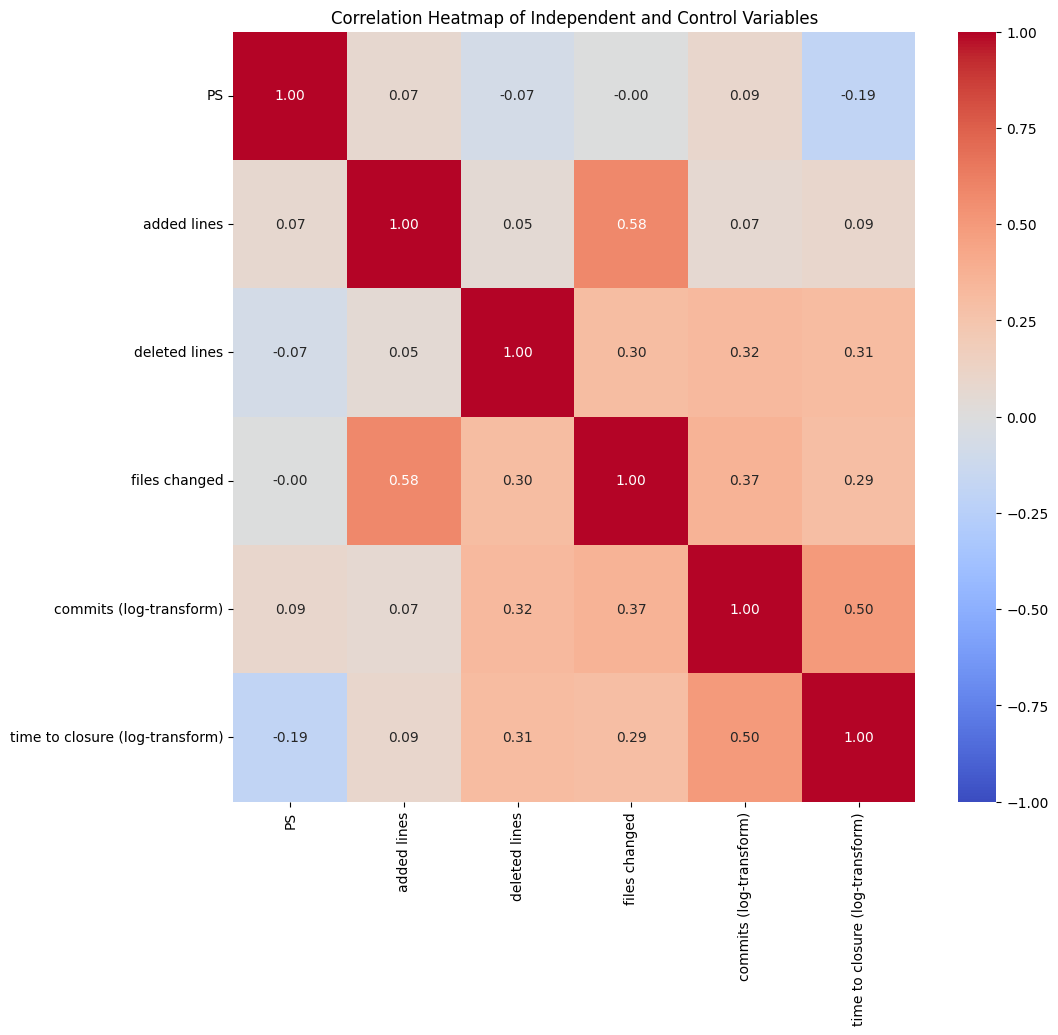

In [337]:
# do check for multi-collinearity
# # List of columns you're interested in
columns_of_interest = ['ps', 'nAdd', 'nDel', 'changeFile', 'nCommits', 'tToClose']
liwc_df_subset = liwc_df[columns_of_interest].copy()
# Rename columns in liwc_df_subset
liwc_df_subset.rename(columns={
    'ps': 'PS', 
    'nAdd': 'added lines', 
    'nDel': 'deleted lines', 
    'changeFile': 'files changed', 
    'nCommits': 'commits (log-transform)', 
    'tToClose': 'time to closure (log-transform)'
}, inplace=True)
corr_matrix = liwc_df_subset.corr()

# Create the heatmap
plt.figure(figsize=(11, 10))  # Adjust the size if necessary
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Independent and Control Variables')
plt.show()